# Example of application to matlab files and (partial) replication of results from Borst and Anderson 2021

In [1]:
import numpy as np
import scipy.io
import os
import xarray as xr
import pyhsmm_mvpa as hsmm
import itertools
import multiprocessing 
import matplotlib.pyplot as plt
from mne import channels

cpus =4

%load_ext autoreload
%autoreload 2


Reading the data

In [2]:
mat = scipy.io.loadmat('matlab/analysis_data_model/data/varForBumps135_100.mat')

data = np.array(mat['normedscore10'])
starts = np.array(mat['x'][:,0]) -1#correcting to be 0 indexed
ends = np.array(mat['y'][:,0])-1#correcting to be 0 indexed
subjects = np.array(mat['subjects'])-1 #correcting to be 0 indexed

#### Converting to xarray format 
durations = ends - starts + 1
limits = np.cumsum(durations)
limits = np.concatenate([[0],limits])
participant, trials = np.unique(subjects, return_counts=True)
unstacked_data = np.tile(np.nan, (len(participant), np.max(trials), np.max(durations), np.shape(data)[1]))

for trial in np.arange(len(durations)):
    if trial > 0 and subjects[trial] == subjects[trial-1]:
        within_trial += 1
    else:
        within_trial = 0
    unstacked_data[subjects[trial], within_trial, :durations[trial],:] = data[limits[trial]:limits[trial+1]]
unstacked_data = xr.DataArray(unstacked_data, coords={'participant':participant,
                                   'epochs':np.arange(np.max(trials)),
                                   'samples':np.arange(np.max(durations)),
                                   'component':np.arange(np.shape(data)[1])
                               })
stacked_data = hsmm.utils.stack_data(unstacked_data, 'participant')

Recreating positions of electrodes

In [3]:
channels_loc = scipy.io.loadmat('matlab/analysis_data_model/analysis/HSMM_code/chanlocs.mat')
positions_dict_i =  [{str(electrode[0][0]):[-electrode[5][0][0]/1000,electrode[4][0][0]/1000,electrode[6][0][0]/1000]} 
                     for electrode in channels_loc['chanlocs'][0]]
positions_dict = {}
for i in positions_dict_i:
     positions_dict.update(i)
montage = channels.make_dig_montage(positions_dict,coord_frame='head')
positions = np.array([x[-1][:2] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
names = np.array([x[0] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
#montage.plot();

Initializing the hsmm object with data, starts, sampling frequency... all things shared across the different following fit

In [4]:
init = hsmm.models.hsmm(stacked_data.data.T, starts, ends, sf=100, bump_width=50, cpus=4)

Estimating n_bump model with backward estimation

In [5]:
filename = 'testing.nc'

if filename not in os.listdir():
    bests = init.backward_estimation(max_starting_points=200)
    bests.to_netcdf('testing.nc')
else:
    bests = xr.open_dataset('testing.nc')
bests

Estimating all solutions for maximal number of bumps (8) with 0 random starting points
Estimating parameters for 8 bumps model
Parameters estimated for 8 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 8, stage: 9, params: 2, component: 10, bump: 8,
                  samples: 300, trial: 14496)
Coordinates:
  * n_bumps      (n_bumps) int64 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -4.131e+04 -3.599e+04 ... -6.592e+04
    parameters   (n_bumps, stage, params) float64 2.0 4.224 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.512 0.8626 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

Plotting the likelihood and estimated bumps

In [6]:
electrodes = xr.DataArray(hsmm.utils.reconstruct(bests.magnitudes, mat['coeff10'][:,:10], 
                            mat['latent10'][:10], np.mean(mat['data'],axis=0)))

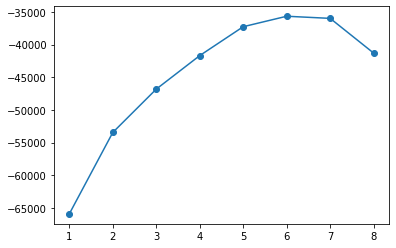

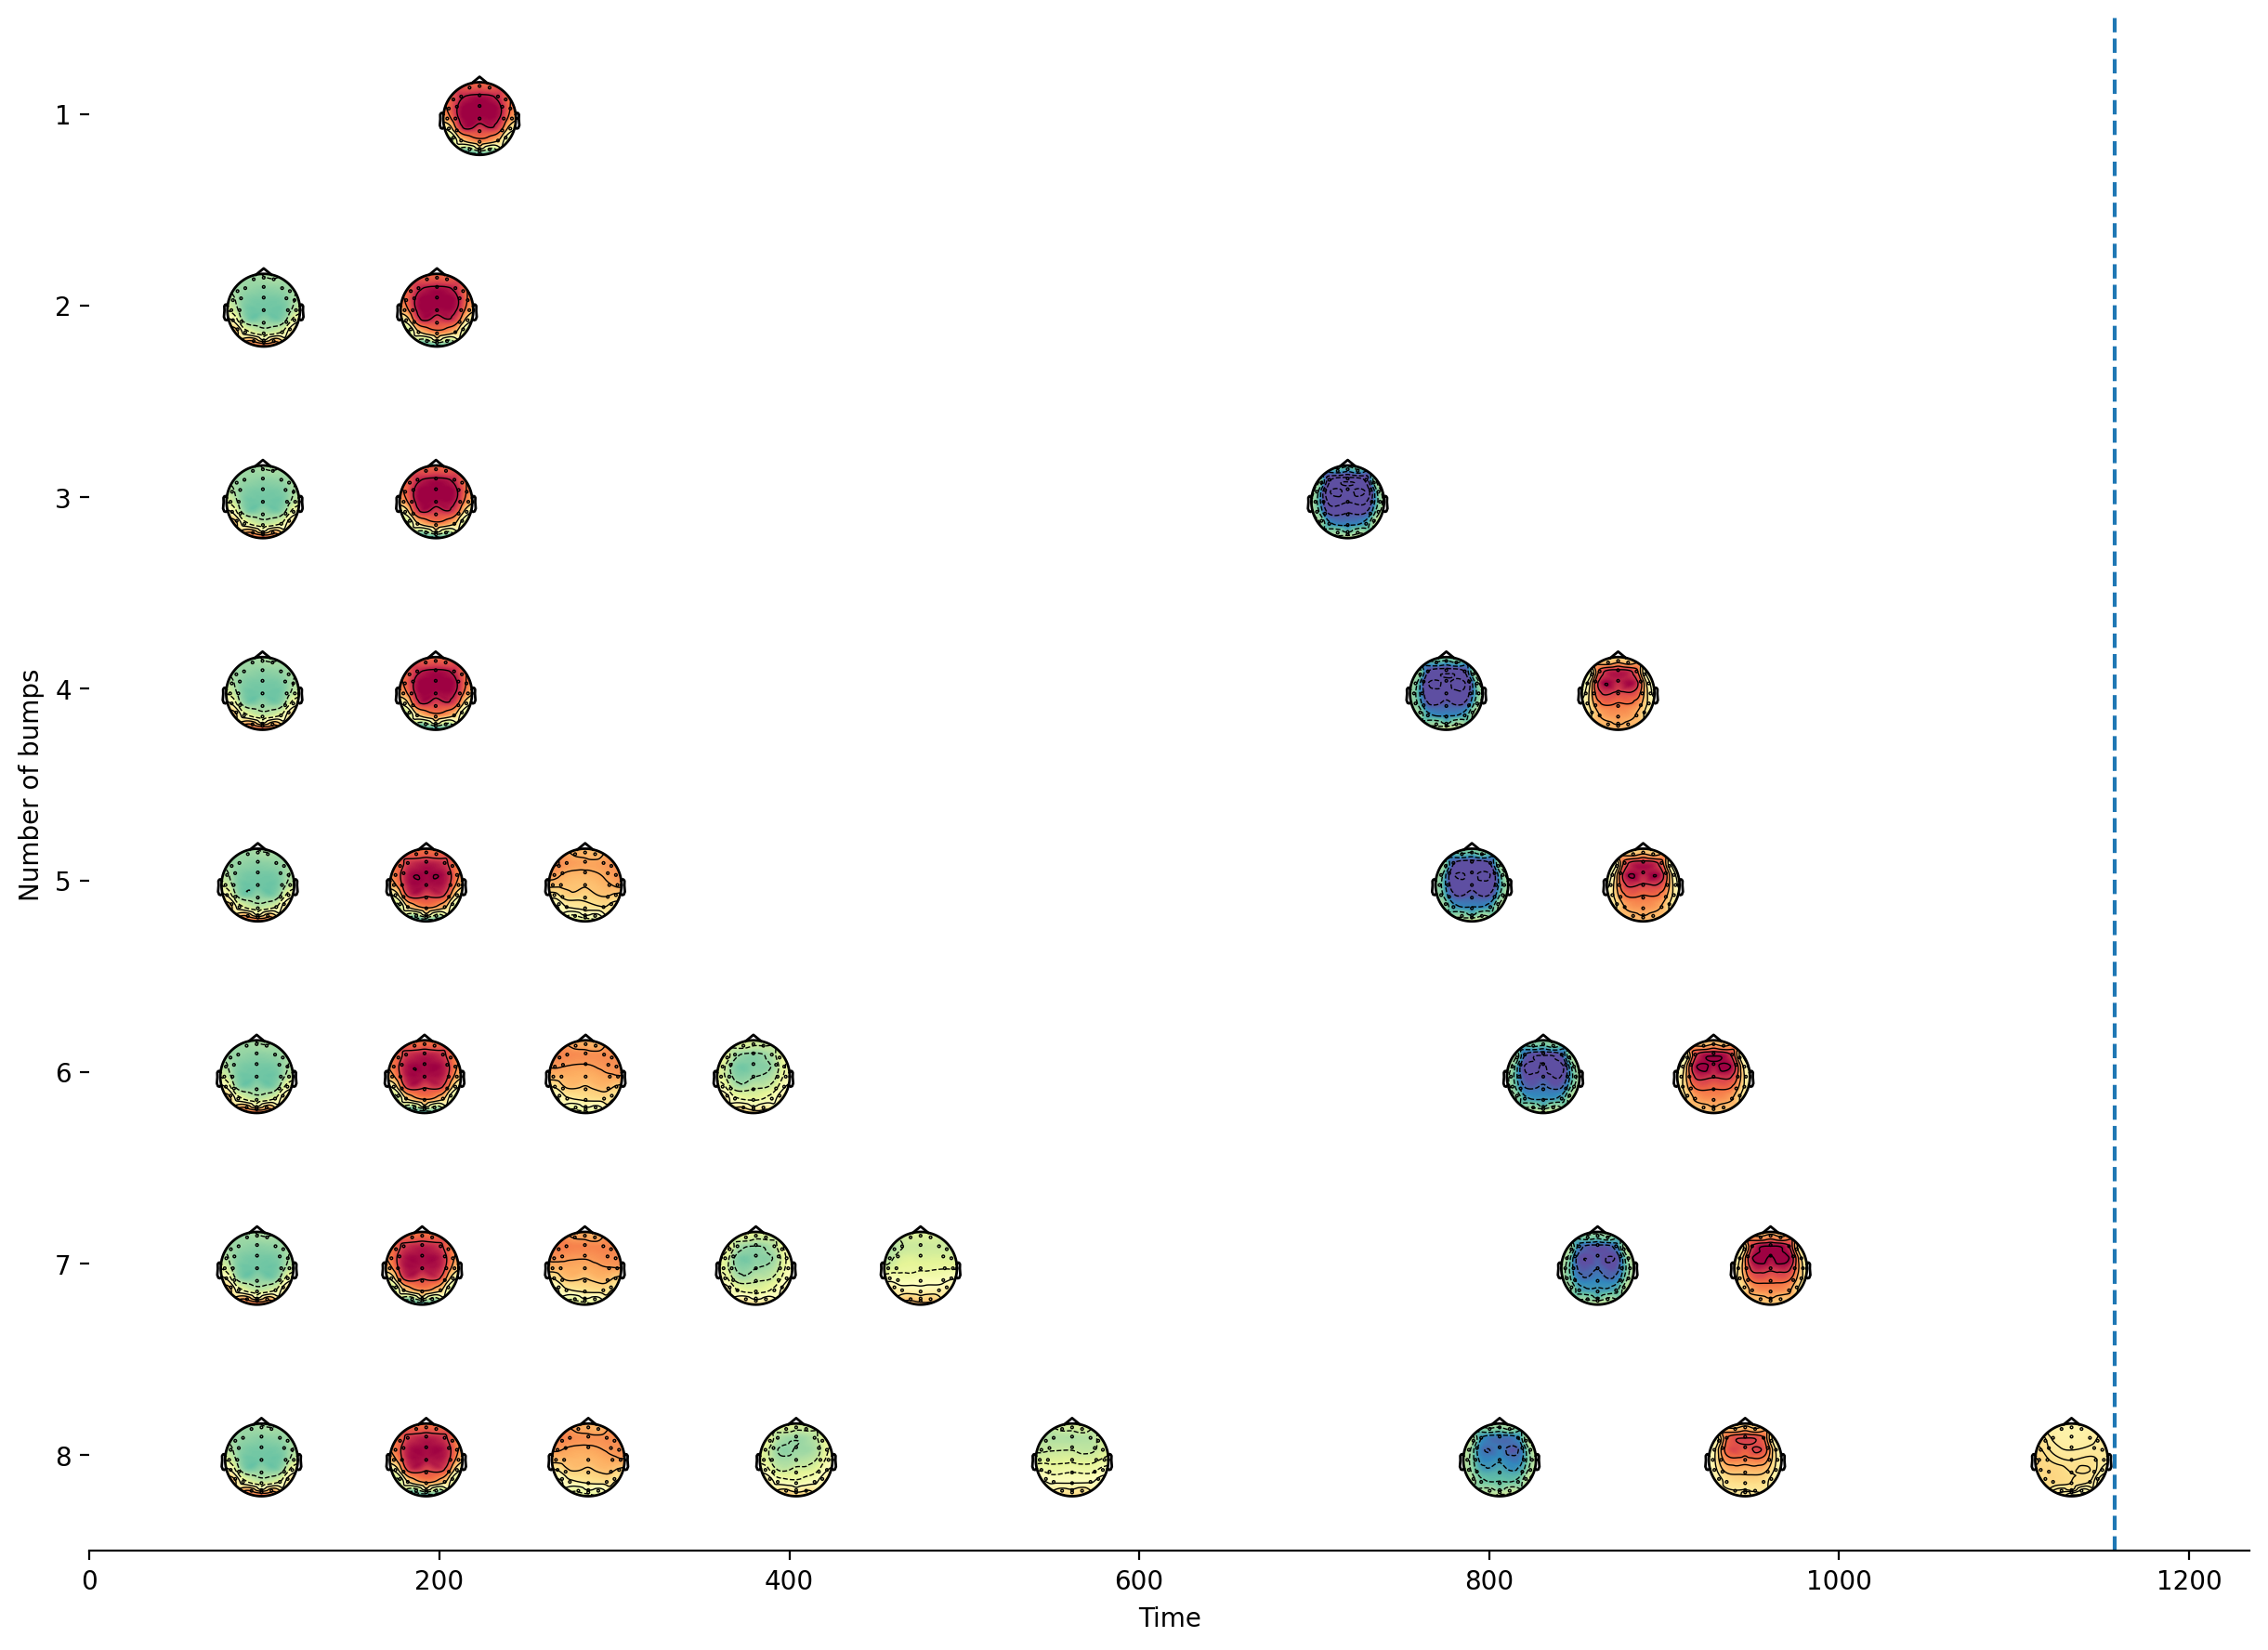

In [7]:
plt.plot(np.arange(init.max_bumps)+1, bests.likelihoods[::-1],'o-')
plt.show()
hsmm.visu.plot_topo_timecourse(electrodes, init.mean_bump_times(bests.eventprobs), positions, bump_size=5, 
                          time_step = 10, magnify=2, mean_rt = np.mean(ends- starts),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps, 0,-1)},
    vmin=-10, vmax=10)

In [8]:
subjects_idx = unstacked_data.participant.data
likelihoods_loo = []
cpus = 4
all_n_bumps = []
for n_bumps in np.arange(1,init.max_bumps+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.utils.LOOCV, 
            zip(itertools.repeat(unstacked_data), subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(100)))
    all_n_bumps.append(loo)

loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})
loocv_covert=loocv

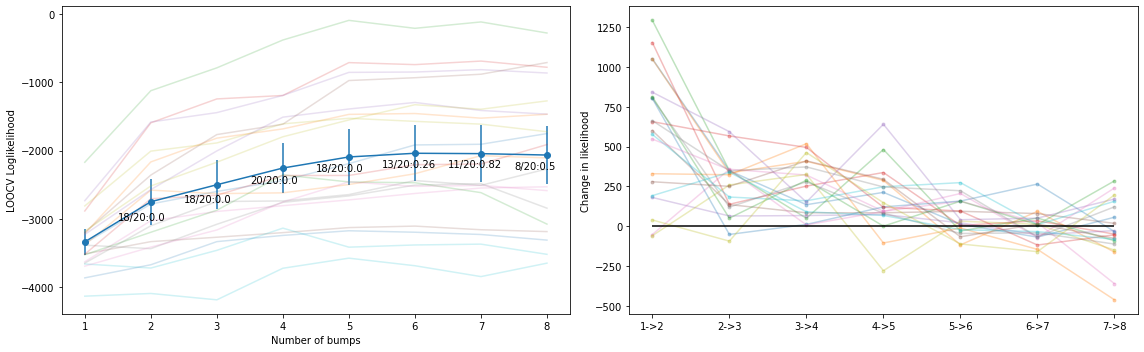

In [9]:
hsmm.visu.plot_LOOCV(loocv, test='sign')

Selecting 5 bumps model

In [10]:
selected = bests.sel(n_bumps=5).drop('n_bumps')
bump_times_selected = init.bump_times(selected.eventprobs)
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)
electrodes_selected = xr.DataArray(hsmm.utils.reconstruct(selected.magnitudes, mat['coeff10'][:,:10], 
                            mat['latent10'][:10], np.mean(mat['data'],axis=0)))

Zoom on topologies

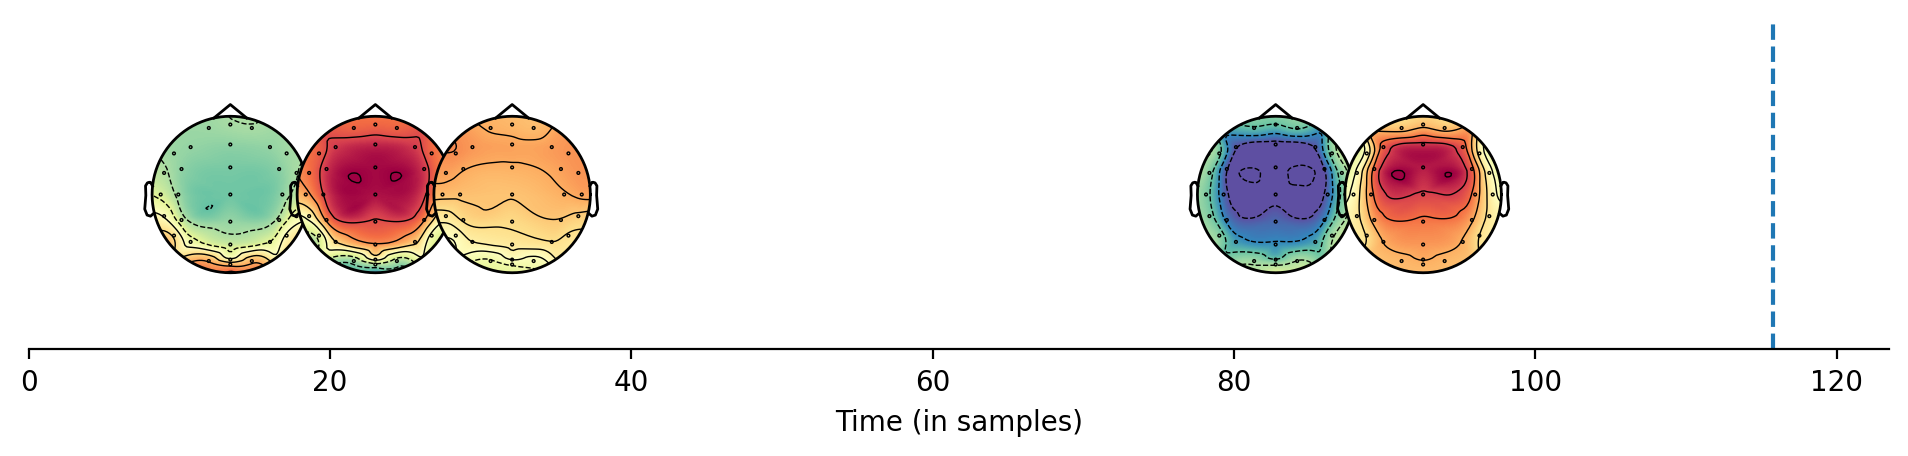

In [11]:
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1,  mean_rt = np.mean(ends - starts),
                                ylabels='5 bumps model', vmin=-10, vmax=10)

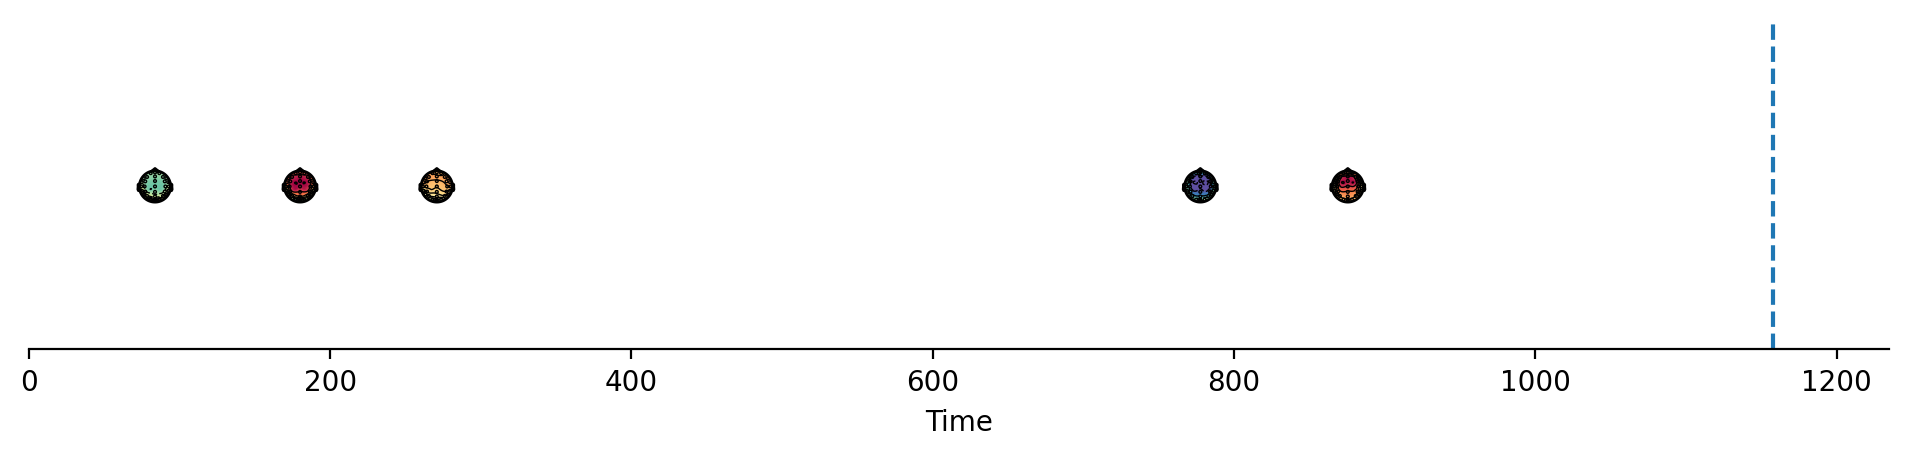

In [12]:
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=1, figsize=(12,2),
                                time_step = 1000/init.sf,  mean_rt = np.mean(ends - starts),
                                ylabels='5 bumps model', vmin=-10, vmax=10)

Plotting the average duration of the stages + bootstrapped confidence intervals (group-level not participant level)

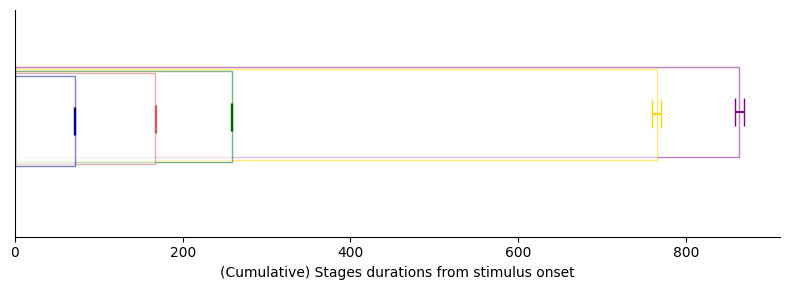

In [13]:
hsmm.visu.plot_latencies_average(bump_times_selected, init.bump_width_samples, 1000/init.sf, errs='ci')